In [1]:
library(data.table)
library(tidyverse)
library(fuzzyjoin)
library(broom)
library(patchwork)
library(ggpubr)
library(ape)
library(tidytree)
library(ggtree)
library(plotly)
library(MASS)
library(Matrix)
library(scales)
library(ggrepel)
library(GGally)
theme_set(theme_pubr(base_size=8, legend="bottom"))
source("../R/helper.R")
options(repr.plot.res = 150)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()

Warning message:
"package 'fuzzyjoin' was built under R version 4.0.3"

Attaching package: 'ape'


The following object is masked from 'package:ggpubr':

    rotate



Attaching package: 'tidytree'


The following object is masked from 'package:stats':

    filter


Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

ggtree v2.0.0  For help: https://yulab-smu.github.io/treedata-boo

In [2]:
args = commandArgs(trailingOnly = TRUE)

In [3]:
#getwd()

In [4]:
#args = c("../../output/greatapes-diversity-data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv","../../output/greatapes-diversity-data/chr12/","figs/","0.4")

In [5]:
#args=c("../../output/joined_stats/sup-rand-id_IXXEAA0KTBNP86TH46_rep_0_win-size_1000000_sample-size_10.tsv","../../output/sims_results/sup-rand-id_IXXEAA0KTBNP86TH46_rep_0_win-size_1000000_sample-size_10/","figs/","0.4")

In [6]:
# Input parameters

## paths
if (length(args) < 4) {
    inpath = '../../output/joined_stats/sup-rand-id_O814WK8MN3UOF27JIR_rep_0_win-size_1000000_sample-size_10.tsv'
    #inpath = '../../output/greatapes-diversity-data/all_pidxy_win-size_1000000_merged-mask_True.tsv'
    outpath = '../../output/'
    figpath = 'figs/'
    prop = 0.4
} else {
    print(args)
    inpath = args[1]
    outpath = args[2]
    figpath = args[3]
    prop = as.numeric(args[4])

}
filemeta = meta_from_fname(inpath, outpath, prop=prop)

[1] "../../output/greatapes-diversity-data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv"
[2] "../../output/greatapes-diversity-data/chr12/"                                                            
[3] "figs/"                                                                                                   
[4] "0.4"                                                                                                     


In [7]:
outpath

[1] "../../output/greatapes-diversity-data/chr12/"

In [8]:
filemeta

$win_size
[1] 1000000

$merged_mask
[1] "True"

$spaced_desc
[1] "win-size=1000000 merged-mask=True state=all curr=all prop-acc=0.4"

$desc
[1] "win-size_1000000_merged-mask_True_state_all_curr_all_prop-acc_0.4"

$prop
[1] 0.4

$is_ga_data
[1] TRUE

$sigma
[1] 0

$state
[1] "all"

$curr
[1] "all"

$chr
[1] "chr12"

In [9]:
# reading annotation tracks
rec_map = fread('../../hg18/decode_rec_map.tsv')
rec_map = rec_map[,c(1,2,3,5)]
colnames(rec_map) = c("chr", "start", "end", "mean_rate")

rep_timing = fread('../../hg18/replication_timing.tsv')
rep_timing$chr = paste0("chr", rep_timing$chr)

exons = fread('../../hg18/annotations/exon.bed.merged', col.names = c("chr", "start", "end"))

phastcons = fread('../../hg18/annotations/phastConsElements44wayPrimates.bed.merged', col.names = c("chr", "start", "end"))

In [10]:
# reading metadata
edges = fread('../../data/meta/edges_meta.tsv', sep="\t", header=T, fill=T)
edges[edges$edge == 'western_gorila']$edge = 'western_gorilla'
edges$edge = str_replace(edges$edge, "_", "-")
edges$parent = str_replace(edges$parent, "_", "-")
root = edges[edges$parent == "",]$edge
edges[edges$edge==root]$gens = edges[edges$edge==root]$N

In [11]:
# getting a newick tree from metadata table and computing distances/MRCAs
treestr = build_nwk(root, as.data.frame(edges[,c("edge", "parent", "gens")]))
tree = read.tree(text=treestr)
write.tree(tree, file="../../output/ga.nwk")
treetbl = as_tibble(tree)
dist_mat = data.frame(dist.nodes(tree))
colnames(dist_mat) = treetbl$label
rownames(dist_mat) = treetbl$label
mrca_mat = data.frame(mrca(tree, full=TRUE))
for (i in 1:nrow(mrca_mat)) {
    for (j in 1:ncol(mrca_mat)) {
        mrca_mat[i,j] = treetbl[treetbl$node==mrca_mat[i,j],]$label
    }
}
colnames(mrca_mat) = treetbl$label
rownames(mrca_mat) = treetbl$label
treetbl=dplyr::left_join(x = treetbl, y = edges[,c("edge", "edge_age_kya", "N", "gen_time")], by=c("label"="edge"))

In [47]:
treestr

[1] "((bornean-orangutan:18654,sumatran-orangutan:18654)orangutans:409731,((eastern-gorilla:7895,western-gorilla:7895)gorilla:287842,(humans:129828,(bonobo:34840,((nigerian-chimp:9400,western-chimp:9400)nigerian-western:7720,(eastern-chimp:7000,central-chimp:7000)eastern-central:10120)chimps:17720)pan:115760)human-pan:92700)african-apes:275950)great-apes:125089;"

In [12]:
# reading stats computed from VCF/treeseq
pidxy = fread(inpath)

# some fixes (that are only necessary for the real data side of things)
# changing from 1-based to 0-based in case of the data side
pidxy$start = pidxy$start-as.integer(filemeta$is_ga_data)
pidxy$spp1 = str_replace(pidxy$spp1, "_", "-")
pidxy$spp2 = str_replace(pidxy$spp2, "_", "-")
pidxy[pidxy$spp1=='homo',]$spp1 = "humans"
pidxy[pidxy$spp2=='homo',]$spp2 = "humans"
pidxy[pidxy$spp1=='western-gorila',]$spp1 = "western-gorilla"
pidxy[pidxy$spp2=='western-gorila',]$spp2 = "western-gorilla"
# masking windows with low accessibility
## TODO: instead of removing the windows, just set the values to NA
pidxy = pidxy[pidxy$n_acc_bases > filemeta$win_size*filemeta$prop,]
if(filemeta$is_ga_data) {
    if (filemeta$chr != "all") {
        pidxy = pidxy[pidxy$chr == filemeta$chr,]
    }
}

In [13]:
inpath

[1] "../../output/greatapes-diversity-data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv"

In [14]:
head(pidxy[pidxy$stat=="dxy"])

value,stat,spp1,spp2,chr,start,end,n_acc_bases,n_snps
<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
0.003271428,dxy,bonobo,central-chimp,chr12,0,1000000,660660,16855
0.004068860,dxy,bonobo,central-chimp,chr12,1000000,2000000,748356,21081
0.003494154,dxy,bonobo,central-chimp,chr12,2000000,3000000,744366,20194
0.004077403,dxy,bonobo,central-chimp,chr12,3000000,4000000,757093,21885
0.003599528,dxy,bonobo,central-chimp,chr12,4000000,5000000,783483,20680
0.004024525,dxy,bonobo,central-chimp,chr12,5000000,6000000,797706,21376


In [15]:
#pidxy = fread(inpath)
head(pidxy)

value,stat,spp1,spp2,chr,start,end,n_acc_bases,n_snps
<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
0.001561743,pi,central-chimp,central-chimp,chr12,0,1000000,660660,14212
0.001847370,pi,central-chimp,central-chimp,chr12,1000000,2000000,748356,17927
0.001852695,pi,central-chimp,central-chimp,chr12,2000000,3000000,744366,17260
0.001936291,pi,central-chimp,central-chimp,chr12,3000000,4000000,757093,18431
0.001874086,pi,central-chimp,central-chimp,chr12,4000000,5000000,783483,17500
0.002002794,pi,central-chimp,central-chimp,chr12,5000000,6000000,797706,17921


In [16]:
# quick summary
pidxy[pidxy$stat=="pi",] %>% 
    group_by(spp1, spp2, stat) %>%
    summarise(m = weighted.mean(value, w=n_acc_bases, na.rm=T))

`summarise()` has grouped output by 'spp1', 'spp2'. You can override using the `.groups` argument.



spp1,spp2,stat,m
<chr>,<chr>,<chr>,<dbl>
bonobo,bonobo,pi,0.0007205164
bornean-orangutan,bornean-orangutan,pi,0.0013715562
central-chimp,central-chimp,pi,0.0016473018
eastern-chimp,eastern-chimp,pi,0.0014467816
eastern-gorilla,eastern-gorilla,pi,0.0006973089
humans,humans,pi,0.0008701499
nigerian-chimp,nigerian-chimp,pi,0.0012697862
sumatran-orangutan,sumatran-orangutan,pi,0.0020501643
western-chimp,western-chimp,pi,0.0007262061


In [17]:
pidxy

value,stat,spp1,spp2,chr,start,end,n_acc_bases,n_snps
<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
0.001561743,pi,central-chimp,central-chimp,chr12,0,1000000,660660,14212
0.001847370,pi,central-chimp,central-chimp,chr12,1000000,2000000,748356,17927
0.001852695,pi,central-chimp,central-chimp,chr12,2000000,3000000,744366,17260
0.001936291,pi,central-chimp,central-chimp,chr12,3000000,4000000,757093,18431
0.001874086,pi,central-chimp,central-chimp,chr12,4000000,5000000,783483,17500
0.002002794,pi,central-chimp,central-chimp,chr12,5000000,6000000,797706,17921
0.001372681,pi,central-chimp,central-chimp,chr12,6000000,7000000,681990,13106
0.001767523,pi,central-chimp,central-chimp,chr12,7000000,8000000,490715,9803
0.001483312,pi,central-chimp,central-chimp,chr12,8000000,9000000,485572,9852


In [18]:
# adding mrca and tmrca labels
qual_stats = c(setdiff(unique(pidxy$stat), c("pi", "dxy")),"n_acc_bases")
pidxy$combo = paste(pidxy$spp1, pidxy$spp2, sep="_")
pidxy[stat == "pi"]$combo = pidxy[stat == "pi"]$spp1
pidxy[stat %in% qual_stats]$combo = pidxy[stat %in% qual_stats]$spp1
tmp = unique(pidxy[,c("spp1","spp2","combo")])
dt=apply(tmp, 1, function(x) dist_mat[x[1],x[2]])
mrca=apply(tmp, 1, function(x) mrca_mat[x[1],x[2]])
tmp = cbind(tmp, dt)
tmp = cbind(tmp, mrca)

In [19]:
setkey(tmp, mrca)
setkey(edges, edge)
tmp = tmp[edges[,c("edge", "ancestral_coding", "N")],]
pidxy=tmp[pidxy, on=.(spp1,spp2)]
combo_levels = tmp$combo[order(tmp$combo!=tmp$mrca, tmp$dt, tmp$ancestral_coding)]
u = tmp %>%
  distinct(mrca, ancestral_coding, dt) %>%
  group_by(mrca, ancestral_coding) %>%
  summarize(meandt = mean(dt))
mrca_levels = u$mrca[order(u$meandt, u$ancestral_coding)]
pidxy$combo = factor(pidxy$combo, levels = combo_levels, labels=str_replace(combo_levels, "_", " "))
# levels ordered by within vs between spp comparison, tmrca, and ancestral coding (tree order)
pidxy$mrca = factor(pidxy$mrca, levels=mrca_levels)

`summarise()` has grouped output by 'mrca'. You can override using the `.groups` argument.



In [20]:
options(repr.plot.width=15, repr.plot.height=20)
# making a plot of pi against quality measures
if(filemeta$is_ga_data) {
    p_piqual = pidxy %>% 
    filter(stat != "dxy") %>%
    pivot_wider(names_from = stat, values_from = value) %>%
    pivot_longer(cols=all_of(qual_stats), names_to = "stat", values_to="value") %>%
    ggplot(aes(y=pi, x=value)) + 
        stat_cor(method="spearman", aes(label = ..rr.label..)) +
        geom_hex() +
        facet_wrap(vars(combo, stat), ncol=6, scales="free")

    p_piqual
    ggsave(paste0(outpath, figpath, "pi-by-qualmetrics_", filemeta$desc, ".pdf"), 
       width=6.5, height=10, scale=2, units="in", limitsize=FALSE)

    # from here we only care about pi and dxy, so dropping other stats
    pidxy = pidxy[!pidxy$stat %in% qual_stats,] 
}

In [21]:
# joining with rec map
pidxy = as.data.table(genome_left_join(pidxy, rec_map, by = c("chr","start", "end"), minoverlap=2)) # minoverlap bc end is not inclusive
pidxy[, percent:= (end.y-start.y)/(end.x-start.x)]
pidxy=pidxy[, .(mean_rec = weighted.mean(mean_rate, percent)), by=setdiff(colnames(pidxy), c("rate", "start.y", "end.y", "chr", "percent", "mean_rate"))]
setnames(pidxy, c("chr.x","start.x", "end.x"), c("chr","start","end"))
pidxy[,c("chr.y") := NULL]

In [22]:
# joining with exons
pidxy = as.data.table(genome_left_join(pidxy, exons, by = c("chr", "start", "end"), minoverlap=2))
pidxy[, percent:= (end.y-start.y)/(end.x-start.x)]
pidxy[is.na(pidxy$percent)]$percent=0
pidxy=pidxy[, .(ex_overlap = sum(percent)), by=setdiff(colnames(pidxy), c("start.y", "chr", "end.y", "percent"))]
setnames(pidxy, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pidxy[, ex_overlap := 100*ex_overlap]
pidxy[,c("chr.y") := NULL]
pidxy[is.na(pidxy$ex_overlap), ]$ex_overlap = 0

# reweighting by number of acc bases in a window
pidxy$ex_overlap = pidxy$ex_overlap * (pidxy$end - pidxy$start) / pidxy$n_acc_bases


In [23]:
# joining with phastcons
pidxy = as.data.table(genome_left_join(pidxy, phastcons, by = c("chr", "start", "end"), minoverlap=2))
pidxy[, percent:= (end.y-start.y)/(end.x-start.x)]
pidxy[is.na(pidxy$percent)]$percent=0
pidxy=pidxy[, .(pcons_overlap = sum(percent)), by=setdiff(colnames(pidxy), c("start.y", "chr", "end.y", "percent"))]
setnames(pidxy, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pidxy[, pcons_overlap := 100*pcons_overlap]
pidxy[,c("chr.y") := NULL]

In [24]:
head(pidxy)

spp1,spp2,combo,dt,mrca,ancestral_coding,N,value,stat,chr,start,end,n_acc_bases,n_snps,i.combo,mean_rec,ex_overlap,pcons_overlap
<chr>,<chr>,<fct>,<dbl>,<fct>,<int>,<int>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001561743,pi,chr12,0,1000000,660660,14212,central-chimp,1.69000,5.9501,3.8849
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001847370,pi,chr12,1000000,2000000,748356,17927,central-chimp,2.98868,3.3991,3.7336
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001852695,pi,chr12,2000000,3000000,744366,17260,central-chimp,1.93936,3.7358,4.1708
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001936291,pi,chr12,3000000,4000000,757093,18431,central-chimp,4.75395,3.0198,3.5059
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001874086,pi,chr12,4000000,5000000,783483,17500,central-chimp,3.14587,4.7710,4.4959
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.002002794,pi,chr12,5000000,6000000,797706,17921,central-chimp,1.83214,1.3470,3.8467


In [25]:
# correlations between rec,ex and pcons, and pidxy
options(warn=-1)
rec_percentile=0.7
pidxy$high_rec = pidxy$mean_rec > quantile(pidxy$mean_rec, rec_percentile, na.rm = T)
pidxy[is.na(pidxy$high_rec),]$high_rec = FALSE
recbin_labels = c("TRUE" = "High recombination (top 10%)",
                 "FALSE" = "Low recombination (bottom 90%)")

In [26]:
options(warn=-1)

cor_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca,high_rec) %>% 
    do(tidy(cor.test(.$value, .$mean_rec, method="spearman"))) %>%
    mutate(harm_ne = focal_harm_ne(mrca))

cor_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca, high_rec) %>% 
    do(tidy(cor.test(.$value, .$ex_overlap, method="spearman"))) %>%
    mutate(harm_ne = focal_harm_ne(mrca))

cor_pcons = pidxy %>%
    group_by(spp1,spp2, dt, mrca, high_rec) %>% 
    do(tidy(cor.test(.$value, .$pcons_overlap, method="spearman"))) %>%
    mutate(harm_ne = focal_harm_ne(mrca))
options(warn=-0)
write.table(cor_rec, paste0(outpath,"cor-pidxy-rec-rate-byrec_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_ex, paste0(outpath,"cor-pidxy-exon-byrec_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_pcons, paste0(outpath,"cor-pidxy-pcons-byrec_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

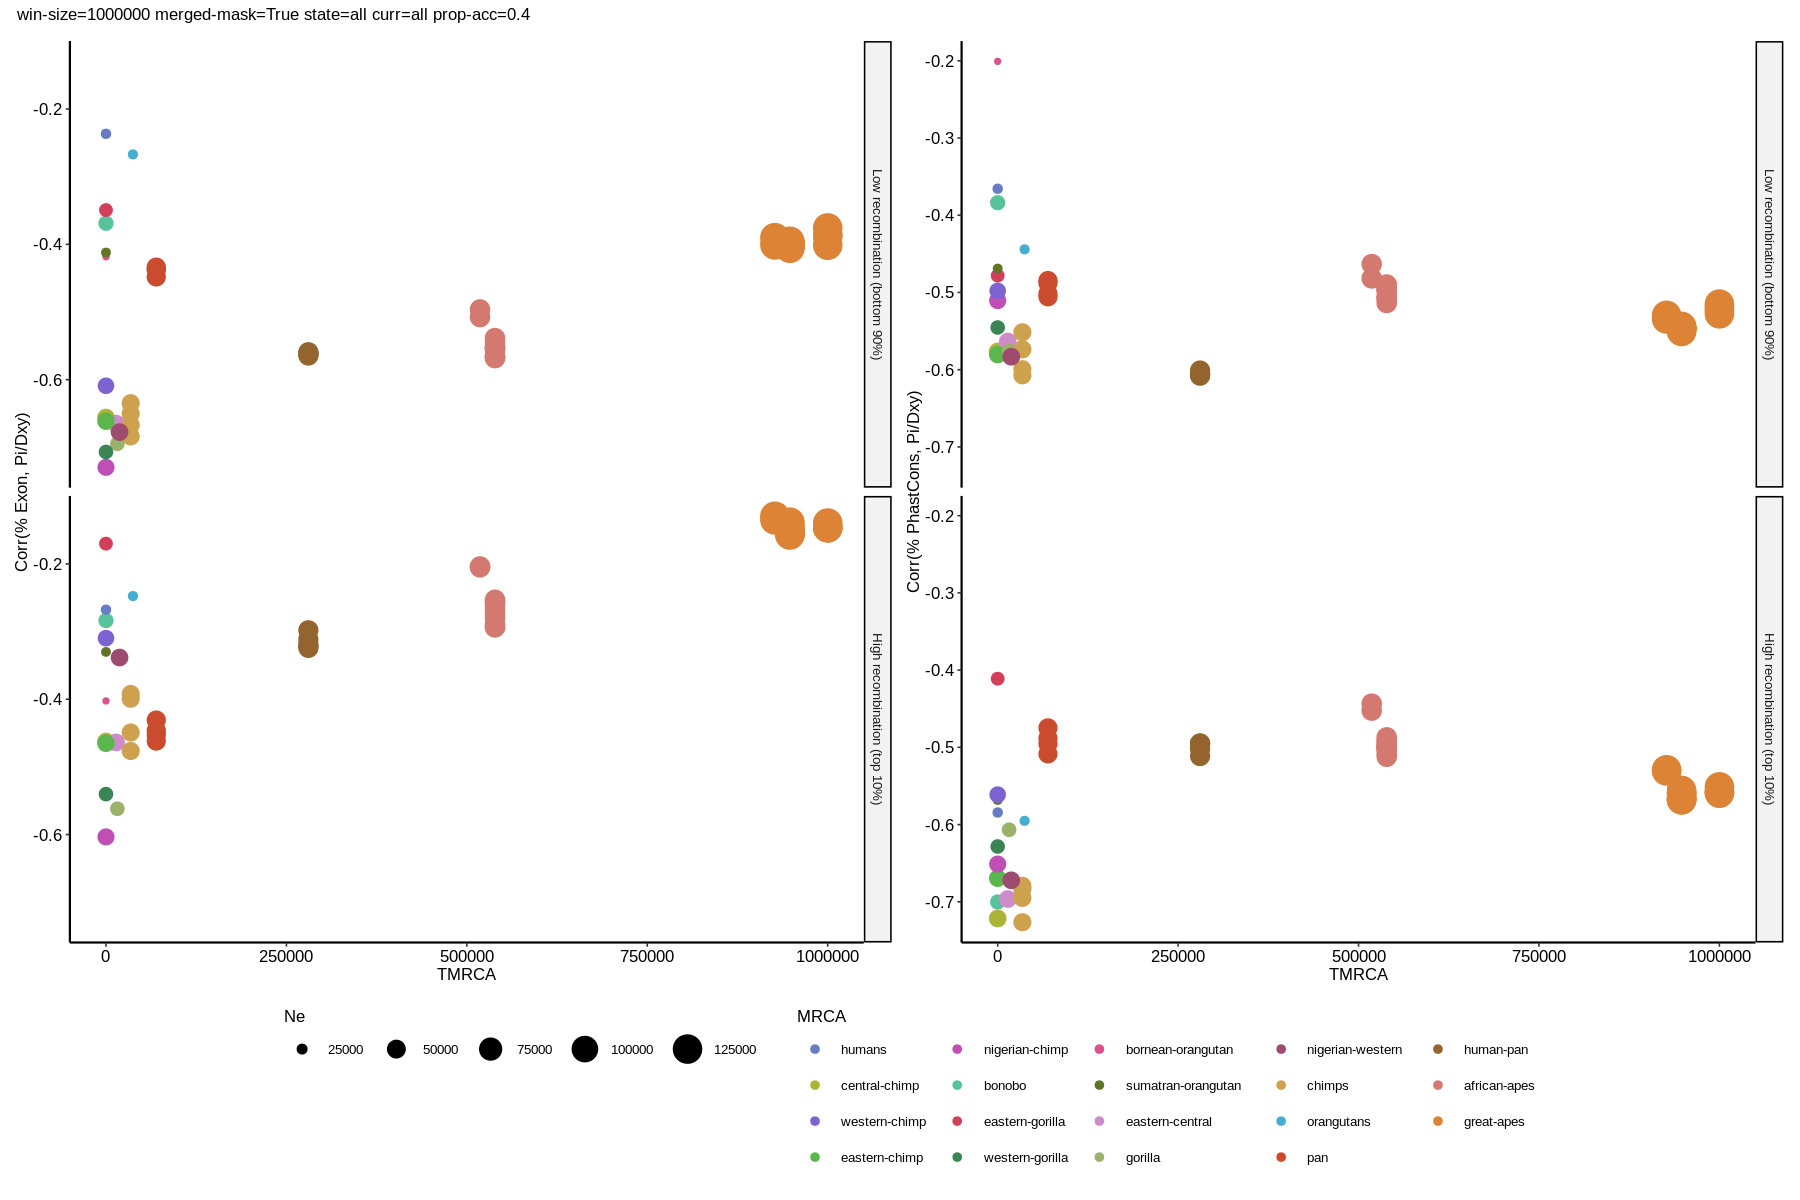

In [27]:
options(repr.plot.width=12, repr.plot.height=8)

col19palette = c("#677cc3","#acb438","#7d63d1","#5ab64d","#bf4fb4","#57c39b","#d33e5a","#3b8455","#db518d","#627527","#cd8bc9","#9cb169","#9d4b6e","#cea14e","#45aecf","#cb4b2e","#94642e","#d4796f","#dd8336")

p_corex_byrec = ggplot(cor_ex, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
            facet_grid(vars(high_rec), labeller = as_labeller(recbin_labels)) +
            geom_point() + 
            scale_colour_manual(values=col19palette) + 
            labs(y="Corr(% Exon, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
            guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))
p_corpcons_byrec = ggplot(cor_pcons, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
                facet_grid(vars(high_rec), labeller = as_labeller(recbin_labels)) +
                geom_point() + 
                scale_colour_manual(values=col19palette) + 
                labs(y="Corr(% PhastCons, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))

p_corex_byrec + p_corpcons_byrec + plot_annotation(subtitle=filemeta$spaced_desc) + plot_layout(guides = 'collect')
ggsave(filename=paste0(outpath, figpath,"annot-correls-tmrca-by-recbin_",filemeta$desc,".pdf"), width = 6.5, height = 4.5, scale=1.2, units = "in")

In [28]:
options(repr.plot.width=12, repr.plot.height=4)

options(warn=-1)

cor_rec = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>% 
    do(tidy(cor.test(.$value, .$mean_rec, method="spearman"))) %>%
    mutate(harm_ne = focal_harm_ne(mrca))

cor_ex = pidxy %>%
    group_by(spp1,spp2,dt, mrca) %>% 
    do(tidy(cor.test(.$value, .$ex_overlap, method="spearman"))) %>%
    mutate(harm_ne = focal_harm_ne(mrca))

cor_pcons = pidxy %>%
    group_by(spp1,spp2, dt, mrca) %>% 
    do(tidy(cor.test(.$value, .$pcons_overlap, method="spearman"))) %>%
    mutate(harm_ne = focal_harm_ne(mrca))
options(warn=-0)
write.table(cor_rec, paste0(outpath,"cor-pidxy-rec-rate_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_ex, paste0(outpath,"cor-pidxy-exon_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(cor_pcons, paste0(outpath,"cor-pidxy-pcons_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

if(0) {
p_correc = ggplot(cor_rec, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) +
            geom_point() + 
            scale_colour_manual(values=col19palette) + 
            labs(y="Corr(Recombination, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))

p_corex = ggplot(cor_ex, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
            geom_point() + 
            scale_colour_manual(values=col19palette) + 
            labs(y="Corr(% Exon, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))

p_corpcons = ggplot(cor_pcons, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
                geom_point() + 
                scale_colour_manual(values=col19palette) + 
                labs(y="Corr(% PhastCons, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))
}

In [29]:
cor_pcons$annot = "pcons"
cor_rec$annot = "rec"
cor_ex$annot = "ex"

In [30]:
cor_annots = rbind(cor_pcons, cor_ex, cor_rec)

In [31]:
cor_annots$annot = factor(cor_annots$annot, levels=c("ex", "rec", "pcons"), labels=c("% exon", "rec rate", "% phastcons"))

In [32]:
p_annot_correls =ggplot(cor_annots, aes(x=dt, y=estimate, col=mrca, size=harm_ne)) + 
                geom_point() + 
                scale_colour_manual(values=col19palette) + 
                labs(y="Corr(Annot, Pi/Dxy)", x="TMRCA", col="MRCA", size="Ne")+
                facet_grid(annot~., scales="free_y") +
                guides(colour = guide_legend(title.position="top"), size = guide_legend(title.position="top"))
ggsave(filename=paste0(outpath,figpath, "annot-correls-tmrca_",filemeta$desc,".pdf"), width = 4, height = 6.5, scale=1.2, units = "in")
saveRDS(p_annot_correls, file = paste0(outpath,"annot-correls-tmrca_",filemeta$desc,".rds"))

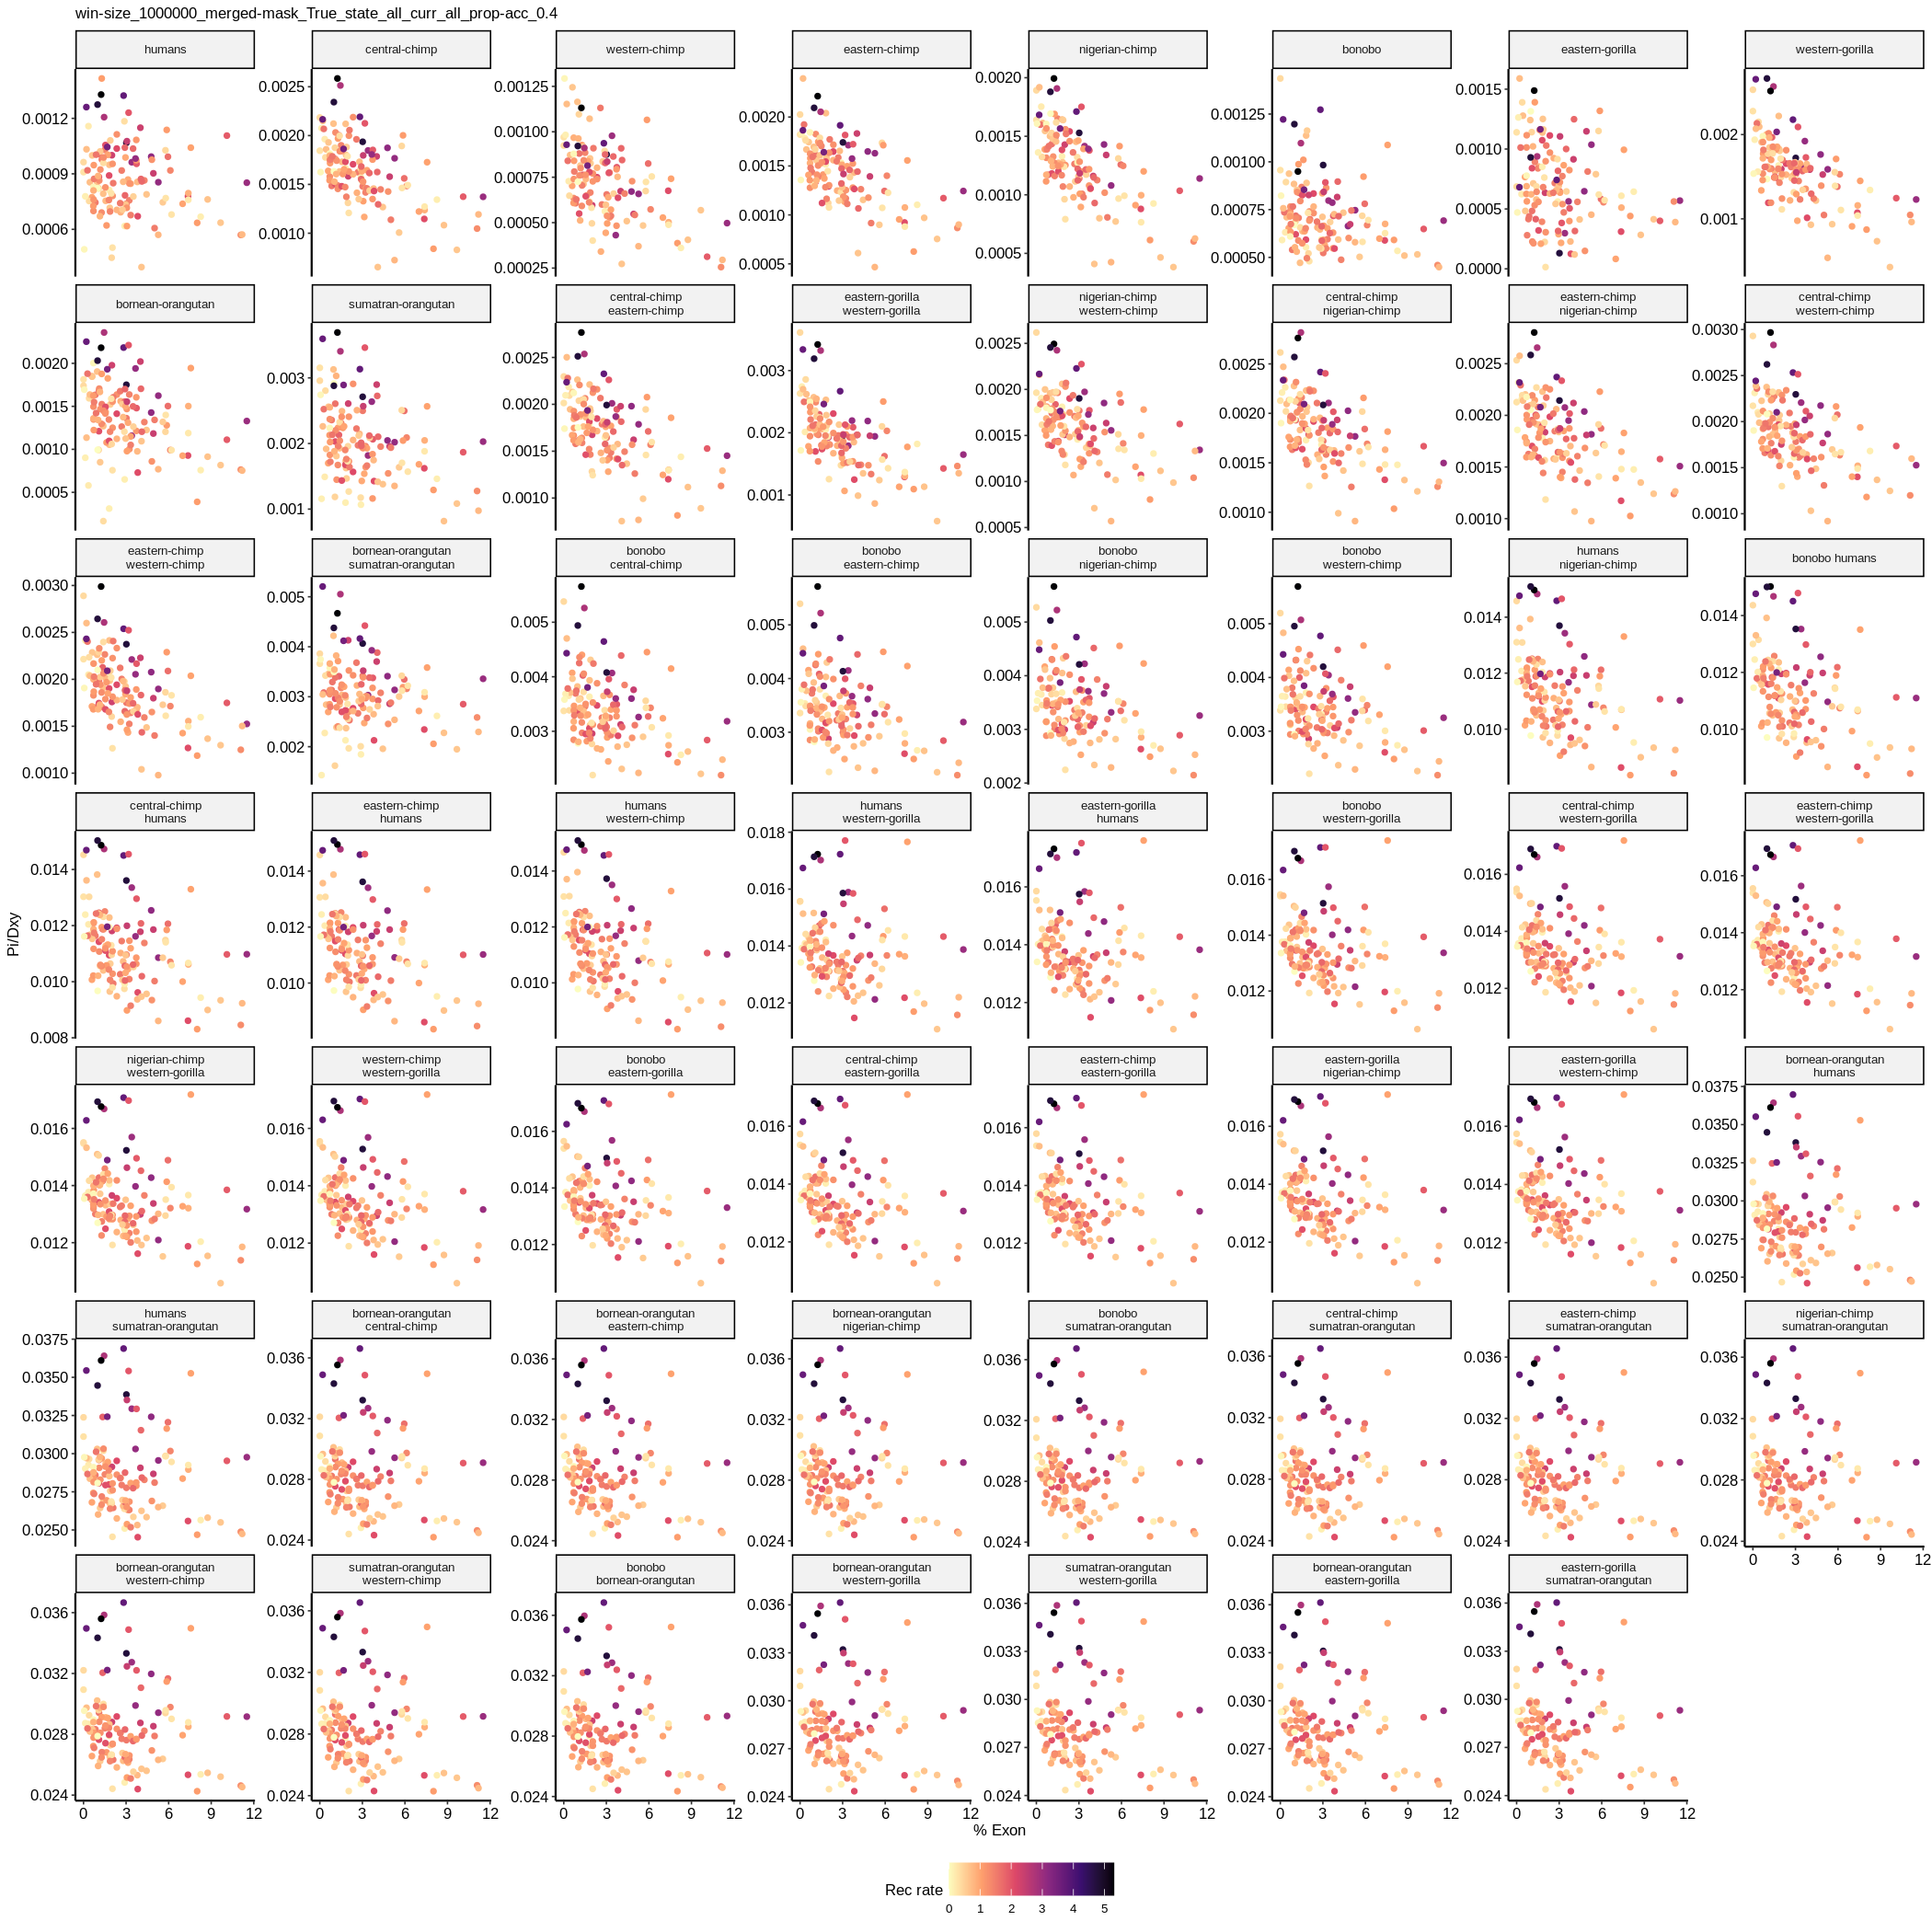

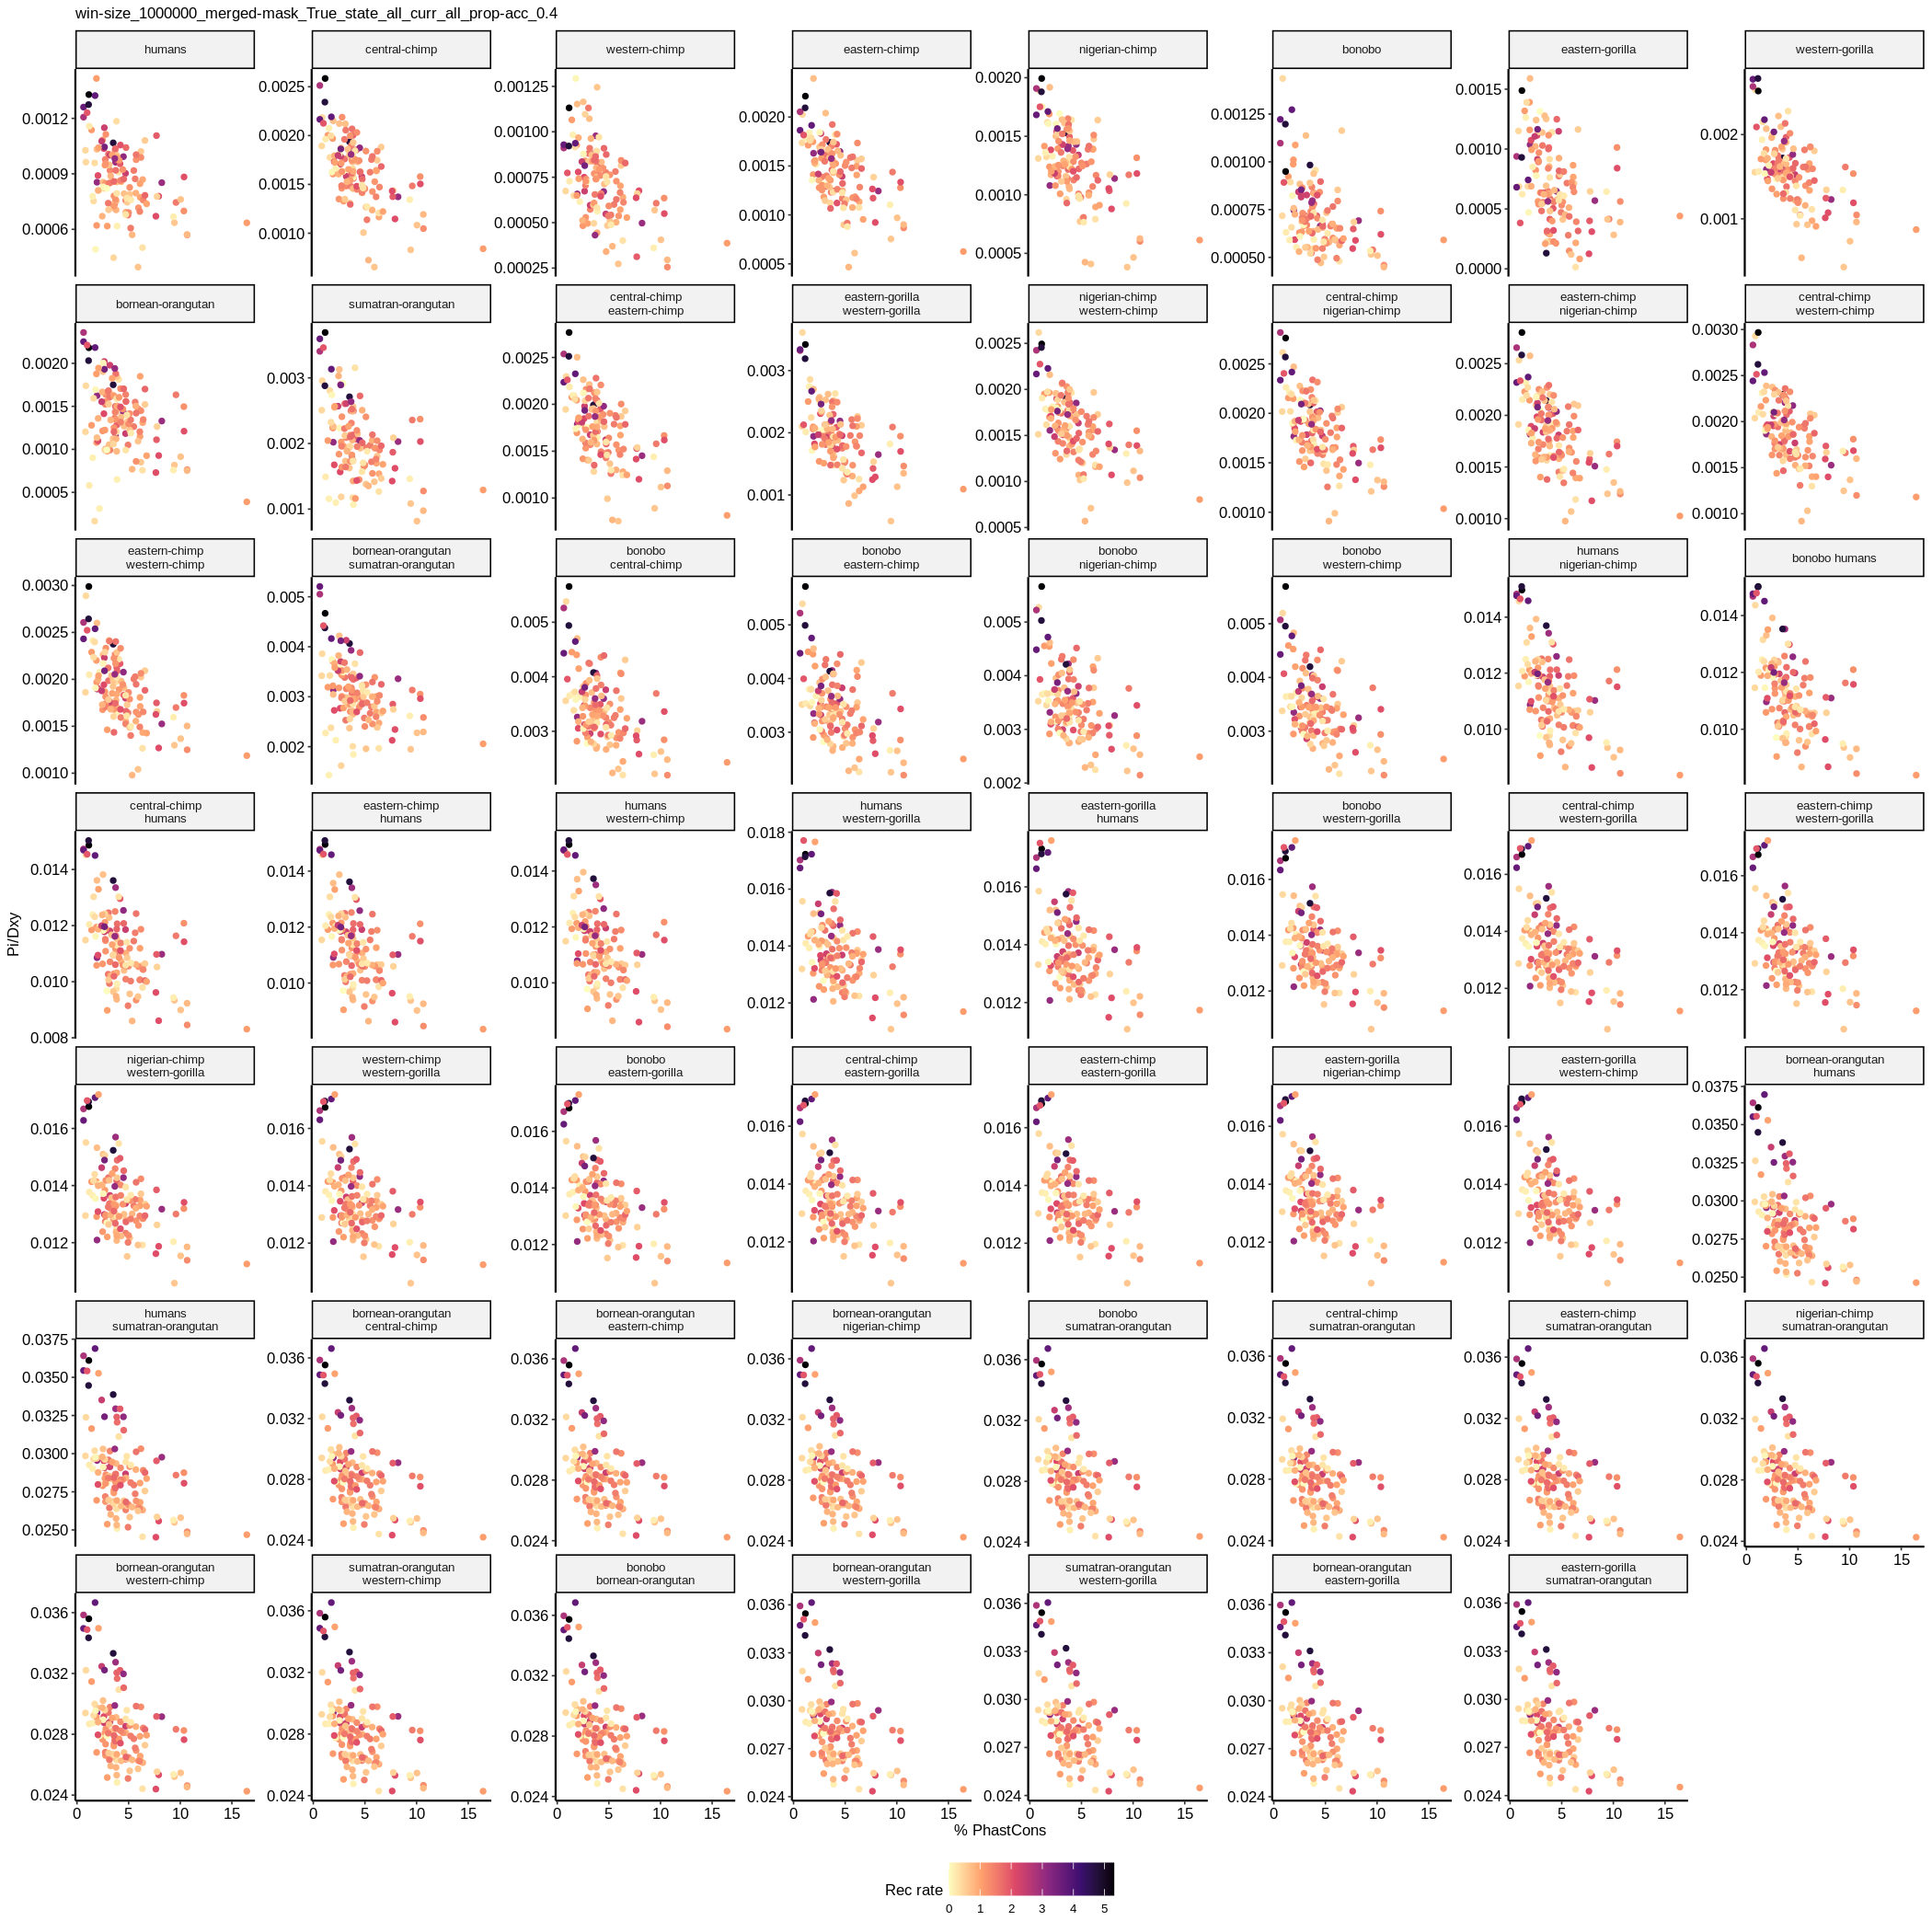

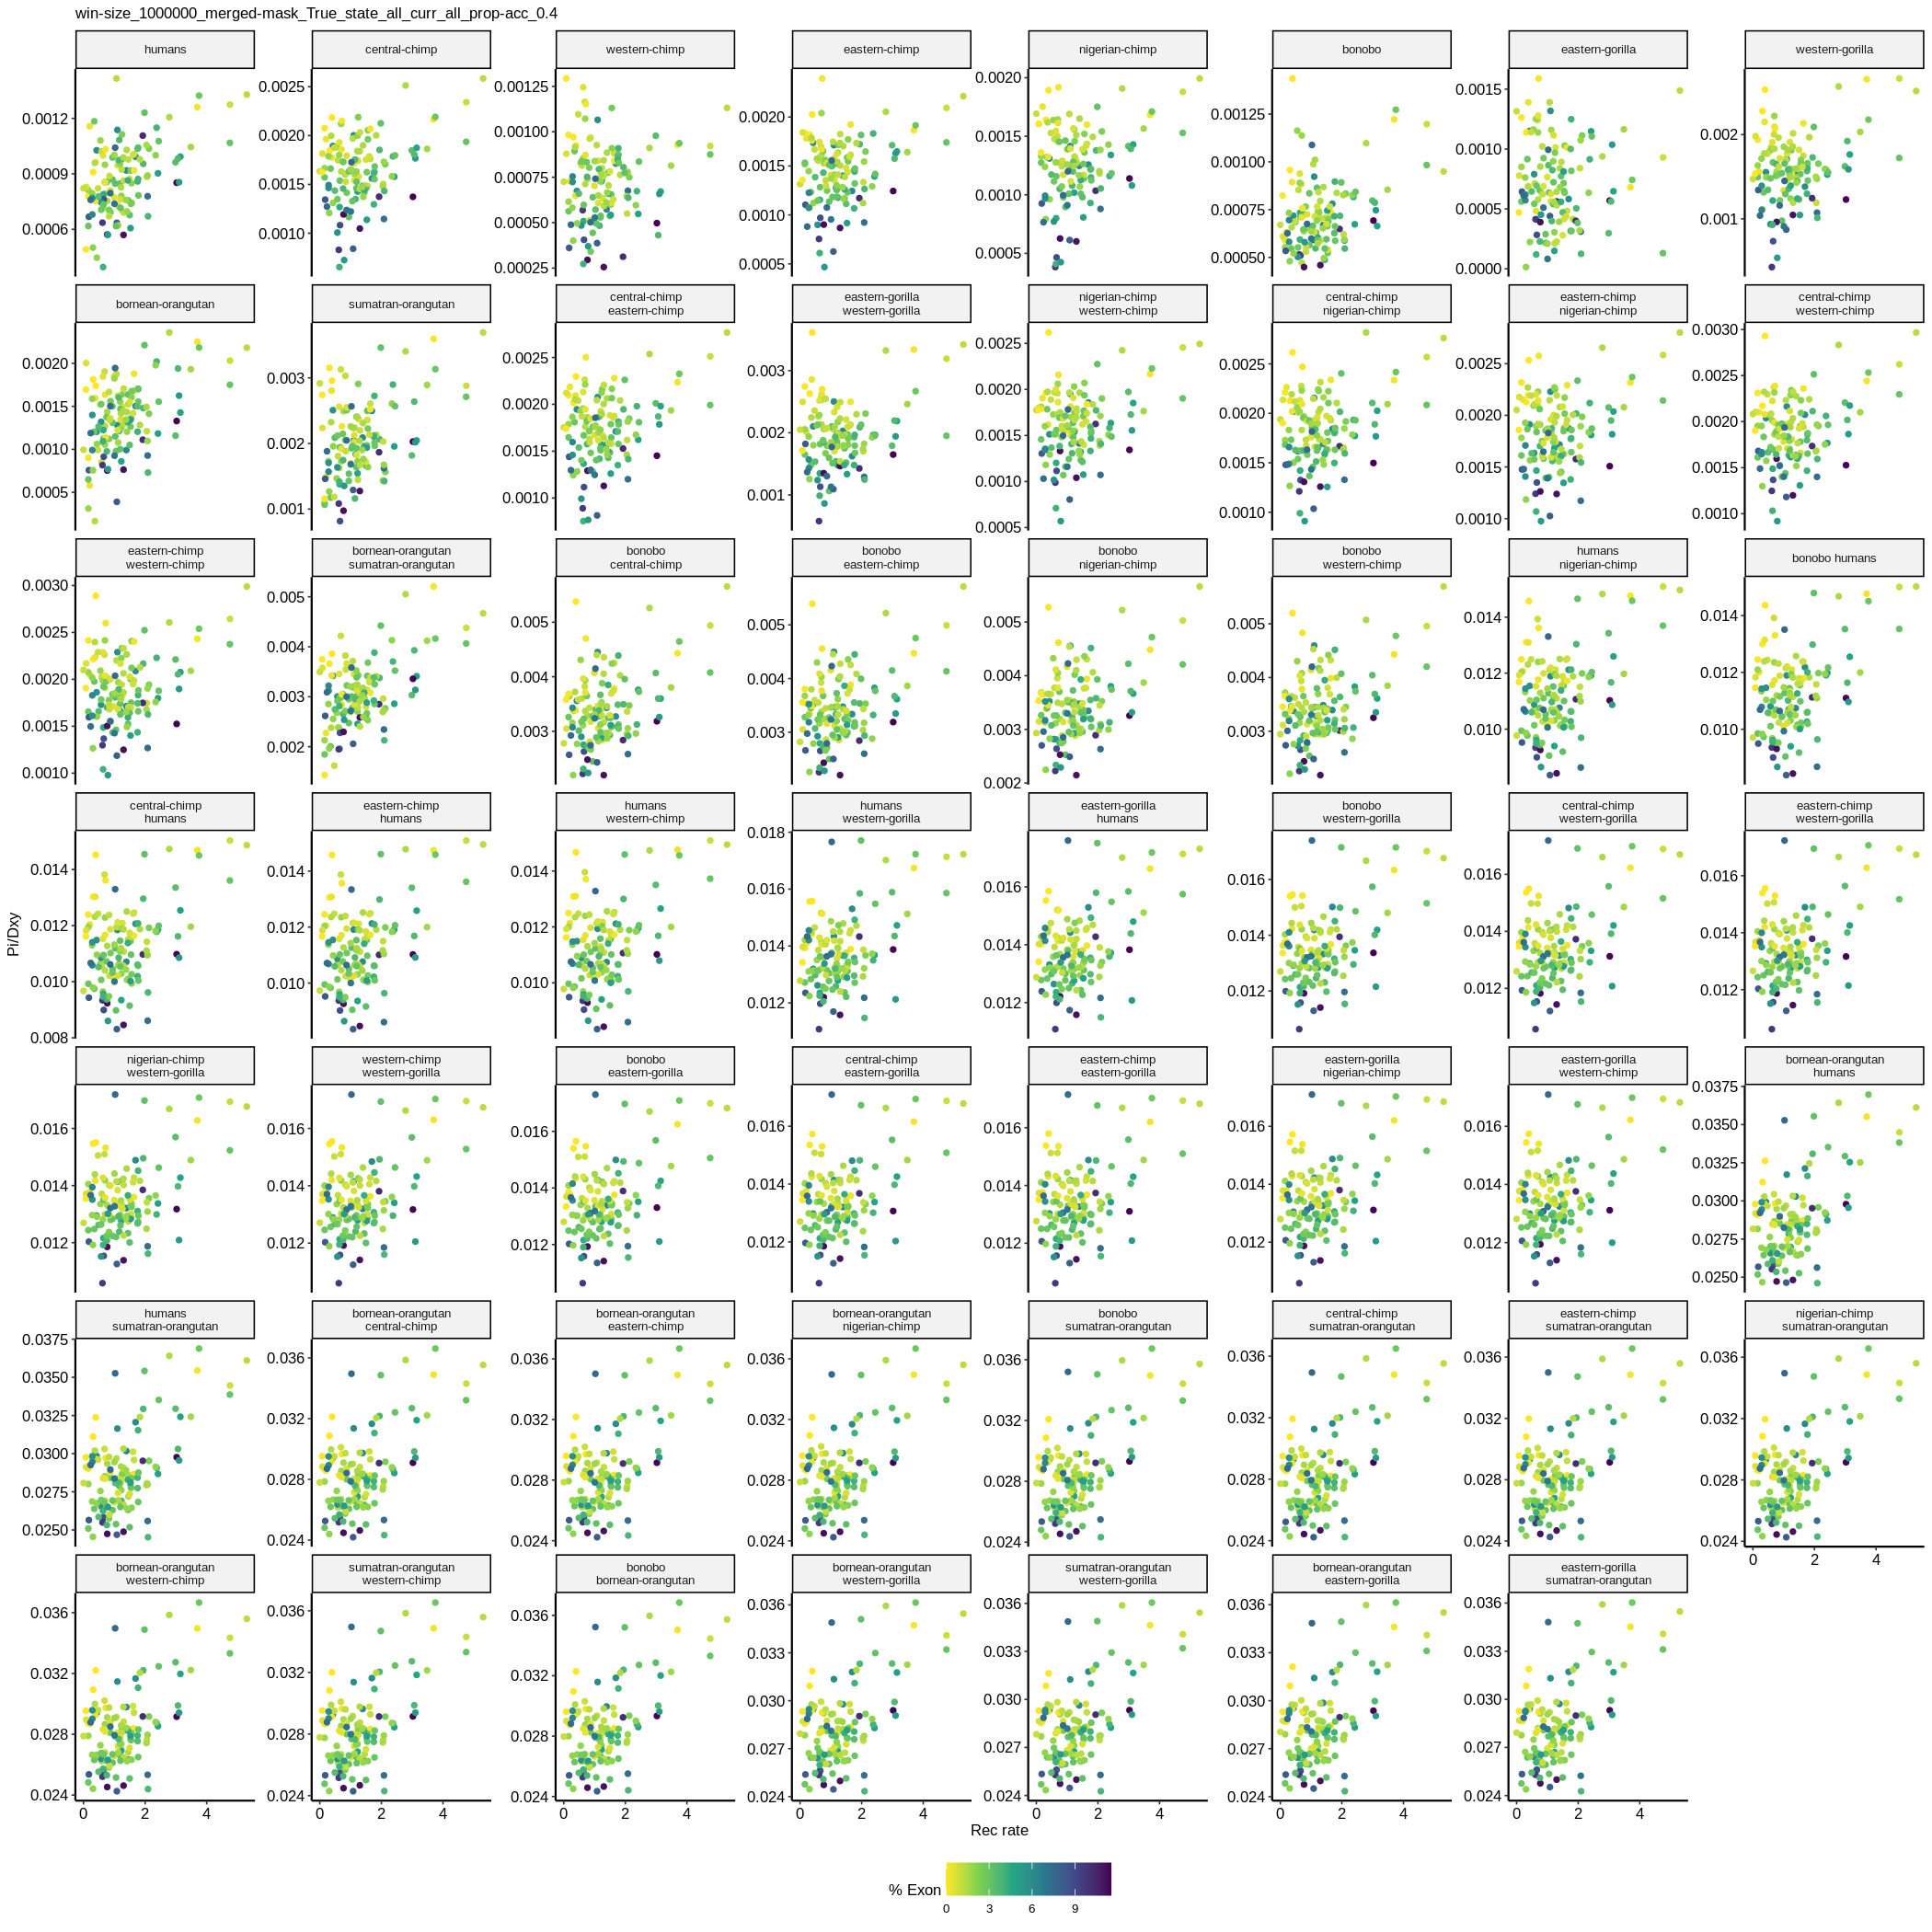

In [33]:
# scatter plots of relationship between pidxy and annotations for each species-pair
options(repr.plot.width=14, repr.plot.height=14)

ggplot(data=pidxy, aes(y=value, x=ex_overlap, col=mean_rec)) +
    geom_point(size=1) +
        facet_wrap(vars(combo), scales="free_y", labeller = label_wrap_gen(width=18)) +
        labs(y="Pi/Dxy", x="% Exon", col="Rec rate", subtitle=filemeta$desc) +
        scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"exon-scatter_",filemeta$desc,".pdf"), width = 6.5, height = 4, scale=3, units = "in")

ggplot(data=pidxy, aes(y=value, x=pcons_overlap, col=mean_rec)) +
    geom_point(size=1) +
    facet_wrap(vars(combo), scales="free_y", labeller = label_wrap_gen(width=18)) +
    labs(y="Pi/Dxy", x="% PhastCons", col="Rec rate", subtitle=filemeta$desc) + 
    scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"pcons-scatter_",filemeta$desc,".pdf"), width = 6.5, height = 4, scale=3, units = "in")

ggplot(data=pidxy, aes(y=value, x=mean_rec, col=ex_overlap)) + 
    geom_point(size=1) + 
    facet_wrap(vars(combo), scales="free_y", labeller = label_wrap_gen(width=18)) + 
    labs(y="Pi/Dxy", x="Rec rate", col="% Exon", subtitle=filemeta$desc) + 
scale_colour_viridis_c(direction=-1)
ggsave(filename=paste0(outpath, figpath,"rec-scatter_",filemeta$desc,".pdf"), width = 6.5, height = 4, scale=3, units = "in")

In [34]:
qrec=90
qex=90
pidxy$dex = cut(pidxy$ex_overlap, 
                breaks=c(-Inf,quantile(pidxy$ex_overlap, qex/100, na.rm=TRUE), Inf), 
                labels=c("LO_EX","HI_EX"))
pidxy$drec = cut(pidxy$mean_rec, 
                breaks=c(-Inf,quantile(pidxy$mean_rec, qrec/100, na.rm=TRUE), Inf), 
                labels=c("LO_REC","HI_REC"))

`summarise()` has grouped output by 'spp1', 'spp2', 'combo', 'stat', 'drec', 'dex'. You can override using the `.groups` argument.

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



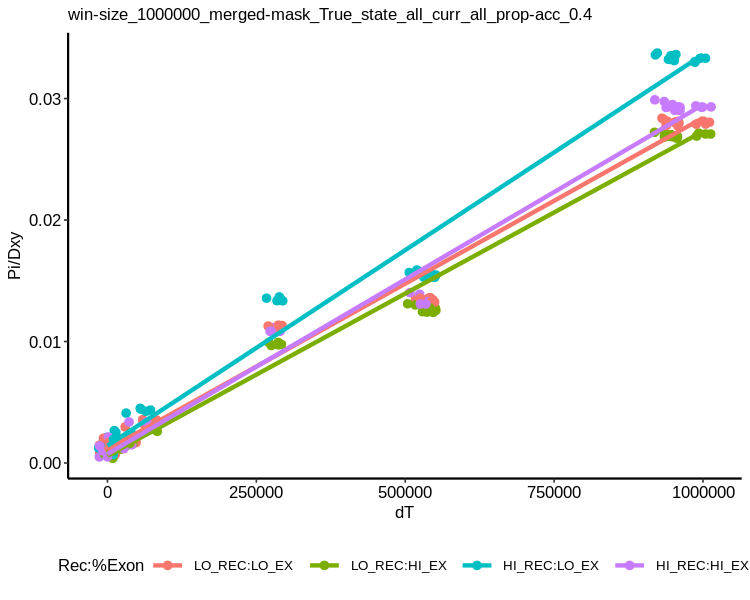

In [35]:
options(repr.plot.width=5, repr.plot.height=4)
pidxy[!is.na(pidxy$mean_rec),] %>%
    group_by(spp1, spp2, combo, stat, drec,dex, dt) %>%
    summarize(meanval=mean(value)) %>%
    ggplot(aes(x=dt, y=meanval, col=drec:dex)) + 
    geom_jitter(width=15000, height=0.0002, ) +
    labs(subtitle=filemeta$desc) +
    #geom_pointrange(stat = "summary",
    #                fun.min = function(z) { mean(z) - sd(z) },
    #                fun.max = function(z) { mean(z) + sd(z) },
    #                fun = mean) +
    geom_smooth(aes(x=dt, y=meanval, col=drec:dex), method="lm", se=FALSE) +
    labs(y="Pi/Dxy", x="dT", col="Rec:%Exon", subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pidxy-change-dt_",filemeta$desc,".pdf"), width = 4, height = 3.5, units = "in")

In [36]:
pidxy

spp1,spp2,combo,dt,mrca,ancestral_coding,N,value,stat,chr,⋯,end,n_acc_bases,n_snps,i.combo,mean_rec,ex_overlap,pcons_overlap,high_rec,dex,drec
<chr>,<chr>,<fct>,<dbl>,<fct>,<int>,<int>,<dbl>,<chr>,<chr>,⋯,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<fct>,<fct>
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001561743,pi,chr12,⋯,1000000,660660,14212,central-chimp,1.690000,5.9501,3.8849,TRUE,LO_EX,LO_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001847370,pi,chr12,⋯,2000000,748356,17927,central-chimp,2.988680,3.3991,3.7336,TRUE,LO_EX,HI_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001852695,pi,chr12,⋯,3000000,744366,17260,central-chimp,1.939360,3.7358,4.1708,TRUE,LO_EX,LO_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001936291,pi,chr12,⋯,4000000,757093,18431,central-chimp,4.753950,3.0198,3.5059,TRUE,LO_EX,HI_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001874086,pi,chr12,⋯,5000000,783483,17500,central-chimp,3.145870,4.7710,4.4959,TRUE,LO_EX,HI_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.002002794,pi,chr12,⋯,6000000,797706,17921,central-chimp,1.832140,1.3470,3.8467,TRUE,LO_EX,LO_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001372681,pi,chr12,⋯,7000000,681990,13106,central-chimp,3.024850,11.5100,8.2097,TRUE,HI_EX,HI_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001767523,pi,chr12,⋯,8000000,490715,9803,central-chimp,3.103280,5.2725,1.9370,TRUE,LO_EX,HI_REC
central-chimp,central-chimp,central-chimp,0,central-chimp,2,30000,0.001483312,pi,chr12,⋯,9000000,485572,9852,central-chimp,1.390840,6.1203,3.1951,FALSE,LO_EX,LO_REC


In [37]:
widepidxy = pidxy %>%
    pivot_wider(id_cols = c("chr", "start", "end", "drec", "dex"), names_from=c("stat","combo"), values_from = value)

cormat = cor(widepidxy%>%dplyr::select(-c("chr", "start", "end", "drec", "dex")), method="spearman", use="complete.obs")
cormat[upper.tri(cormat)] <- NA

longcor = reshape2::melt(cormat)
if(1) {
colnames(longcor) = c("stat_combo1", "stat_combo2", "value")
longcor = longcor[!is.na(longcor$value),]
tmp = unique(pidxy[,c("spp1", "spp2","stat","combo","mrca")])
tmp$sc = paste(tmp$stat, tmp$combo, sep="_")

longcor = left_join(longcor, tmp[,c("mrca","stat", "sc", "spp1", "spp2")], by=c("stat_combo1"="sc"))}

In [45]:
dist_mat

,bornean-orangutan,sumatran-orangutan,eastern-gorilla,western-gorilla,humans,bonobo,nigerian-chimp,western-chimp,eastern-chimp,central-chimp,great-apes,orangutans,african-apes,gorilla,human-pan,pan,chimps,nigerian-western,eastern-central
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bornean-orangutan,0,37308,1000072,1000072,926863,947635,947635,947635,947635,947635,428385,18654,704335,992177,797035,912795,930515,938235,940635
sumatran-orangutan,37308,0,1000072,1000072,926863,947635,947635,947635,947635,947635,428385,18654,704335,992177,797035,912795,930515,938235,940635
eastern-gorilla,1000072,1000072,0,15790,518265,539037,539037,539037,539037,539037,571687,981418,295737,7895,388437,504197,521917,529637,532037
western-gorilla,1000072,1000072,15790,0,518265,539037,539037,539037,539037,539037,571687,981418,295737,7895,388437,504197,521917,529637,532037
humans,926863,926863,518265,518265,0,280428,280428,280428,280428,280428,498478,908209,222528,510370,129828,245588,263308,271028,273428
bonobo,947635,947635,539037,539037,280428,0,69680,69680,69680,69680,519250,928981,243300,531142,150600,34840,52560,60280,62680
nigerian-chimp,947635,947635,539037,539037,280428,69680,0,18800,34240,34240,519250,928981,243300,531142,150600,34840,17120,9400,27240
western-chimp,947635,947635,539037,539037,280428,69680,18800,0,34240,34240,519250,928981,243300,531142,150600,34840,17120,9400,27240
eastern-chimp,947635,947635,539037,539037,280428,69680,34240,34240,0,14000,519250,928981,243300,531142,150600,34840,17120,24840,7000


In [38]:
colnames(longcor) = c("stat_combo1", "stat_combo2", "value", "mrca1", "stat1", "spp1_1", "spp2_1")

In [39]:
longcor = left_join(longcor, tmp[,c("mrca", "stat","sc", "spp1", "spp2")], by=c("stat_combo2"="sc"))

In [40]:
colnames(longcor)[8] = "mrca2"
colnames(longcor)[9] = "stat2"
colnames(longcor)[10] = "spp1_2"
colnames(longcor)[11] = "spp2_2"

In [41]:
longcor$granmrca = apply(longcor, 1, function(x) mrca_mat[x[4],x[8]])
longcor$dt = apply(longcor, 1, function(x) dist_mat[x[4],x[8]])
longcor$statcombo=apply(longcor, 1, function(x) paste(sort(c(x[5], x[9])), collapse="_"))
longcor = longcor[longcor$stat_combo1!=longcor$stat_combo2,] 

In [44]:
longcor[longcor$stat_combo2 == "pi_central-chimp",]

,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,spp1_2,spp2_2,granmrca,dt,statcombo
,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
2,dxy_bonobo central-chimp,pi_central-chimp,0.7971769,pan,dxy,bonobo,central-chimp,central-chimp,pi,central-chimp,central-chimp,pan,34840,dxy_pi
3,dxy_bornean-orangutan central-chimp,pi_central-chimp,0.6461035,great-apes,dxy,bornean-orangutan,central-chimp,central-chimp,pi,central-chimp,central-chimp,great-apes,519250,dxy_pi
4,pi_western-gorilla,pi_central-chimp,0.8222551,western-gorilla,pi,western-gorilla,western-gorilla,central-chimp,pi,central-chimp,central-chimp,african-apes,539037,pi_pi
5,dxy_bonobo western-gorilla,pi_central-chimp,0.7217297,african-apes,dxy,bonobo,western-gorilla,central-chimp,pi,central-chimp,central-chimp,african-apes,243300,dxy_pi
6,dxy_bornean-orangutan western-gorilla,pi_central-chimp,0.6354987,great-apes,dxy,bornean-orangutan,western-gorilla,central-chimp,pi,central-chimp,central-chimp,great-apes,519250,dxy_pi
7,dxy_central-chimp western-gorilla,pi_central-chimp,0.7225794,african-apes,dxy,central-chimp,western-gorilla,central-chimp,pi,central-chimp,central-chimp,african-apes,243300,dxy_pi
8,dxy_eastern-chimp western-gorilla,pi_central-chimp,0.7245248,african-apes,dxy,eastern-chimp,western-gorilla,central-chimp,pi,central-chimp,central-chimp,african-apes,243300,dxy_pi
9,dxy_eastern-gorilla western-gorilla,pi_central-chimp,0.8043381,gorilla,dxy,eastern-gorilla,western-gorilla,central-chimp,pi,central-chimp,central-chimp,african-apes,531142,dxy_pi
10,dxy_humans western-gorilla,pi_central-chimp,0.6919443,african-apes,dxy,humans,western-gorilla,central-chimp,pi,central-chimp,central-chimp,african-apes,243300,dxy_pi


In [ ]:
longcor

In [ ]:
longcor$p1 = apply(longcor,1,function(x) sapply(nodepath(tree, label_to_id(x[6], treetbl), label_to_id(x[7], treetbl)), id_to_label, treetbl=treetbl))
longcor[longcor$stat1=="dxy",]$p1 = apply(longcor[longcor$stat1=="dxy",],1, function(x) setdiff(x[15][[1]], x[4]))

In [ ]:
longcor$p2 = apply(longcor,1,function(x) sapply(nodepath(tree, label_to_id(x[10], treetbl), label_to_id(x[11], treetbl)), id_to_label, treetbl=treetbl))
longcor[longcor$stat2=="dxy",]$p2 = apply(longcor[longcor$stat2=="dxy",],1, function(x) setdiff(x[16][[1]], x[8]))

In [ ]:
longcor$shared_p = apply(longcor, 1, function(x) intersect(x[15][[1]],x[16][[1]]))

In [ ]:
longcor$shared  = apply(longcor, 1, function(x) sum(unlist(sapply(x[17][[1]], function(y) edges[edges$edge==y]$gens))))
longcor$denom_px  = apply(longcor, 1, function(x) sum(unlist(sapply(x[15][[1]], function(y) edges[edges$edge==y]$gens))))
longcor$denom_py  = apply(longcor, 1, function(x) sum(unlist(sapply(x[16][[1]], function(y) edges[edges$edge==y]$gens))))

In [ ]:
#longcor[longcor$stat1 == "pi",]$denom_px = 2*longcor[longcor$stat1 == "pi",]$denom_px
#longcor[longcor$stat2 == "pi",]$denom_py = 2*longcor[longcor$stat2 == "pi",]$denom_py

In [ ]:
longcor$px = longcor$shared / longcor$denom_px
longcor$py = longcor$shared / longcor$denom_py

In [ ]:
longcor$sqsqpxpy = (longcor$px * longcor$py) ^ (1/4)

In [ ]:
longcor

In [ ]:
longcor[longcor$spp1_1 == "humans" & longcor$spp2_1 == "humans",]

In [ ]:
ne_spp = c("eastern-gorilla", "western-chimp", "bonobo")
ne_combo = paste0("pi_",ne_spp)
longcor$lowne=apply(longcor, 1, function(x) any(ne_combo %in% x[1])) | apply(longcor, 1, function(x) any(ne_combo %in% x[2]))

In [ ]:
longcor$num_spp = apply(longcor, 1, function(x) length(unique(c(strsplit(str_remove(x[1], "dxy_|pi_"), " ")[[1]], strsplit(str_remove(x[2], "dxy_|pi_"), " ")[[1]]))))

In [ ]:
head(longcor[longcor$spp1_1=="central-chimp" & longcor$spp2_1=="humans" & longcor$spp1_2=="central-chimp",])

In [ ]:
longcor$has_shared = longcor$shared>1e-16

In [ ]:
harmmeanne=apply(longcor[longcor$has_shared==TRUE,], 1, function(x) mean(unlist(sapply(x[17][[1]], function(y) edges[edges$edge==y]$N))))

In [ ]:
harmmeanne = unname(harmmeanne)

In [ ]:
longcor$harmne = NA

In [ ]:
longcor[longcor$has_shared==TRUE,]$harmne = harmmeanne

In [ ]:
head(longcor)

In [ ]:
colnames(pidxy)

In [ ]:
colnames(widepidxy)

In [ ]:
colss = colnames(widepidxy)

In [ ]:
is_pi = grepl("pi_", colss)
is_dxy = grepl("dxy_", colss)

In [ ]:
sum(is_pi)

In [ ]:
sum(is_dxy)

In [ ]:
figpath

In [ ]:
colnames(widepidxy)

In [ ]:
PointsWithCor <- function(data, mapping, ..., method = "spearman") {
  x <- eval_data_col(data, mapping$x)
  y <- eval_data_col(data, mapping$y)
  cor <- cor(x, y, method = method, use="complete.obs")
  ggally_points(data, mapping, ...) +
    ggplot2::geom_label(
      data = data.frame(
        x = min(x, na.rm = TRUE),
        y = max(y, na.rm = TRUE),
        lab = round(cor, digits = 3)
      ),
      mapping = ggplot2::aes(x = x, y = y, label = lab),
      hjust = 0, vjust = 1,
      size = 5, fontface = "bold",
      inherit.aes = FALSE # do not inherit anything from the ...
    )
}

In [ ]:
colnames(widepidxy)

In [ ]:
scatter_ex1 = widepidxy %>% ggplot(aes(x=`pi_central-chimp`, y=`pi_western-gorilla`)) + geom_point() + labs(x="\u03C0 Central-chimp", y="\u03C0 Western-gorilla")

In [ ]:
scatter_ex2 = widepidxy %>% ggplot(aes(x=`pi_central-chimp`, y=`dxy_bornean-orangutan western-gorilla`)) + geom_point() + labs(x="\u03C0 Central-chimp", y="Dxy Bornean-orangutan Western-gorilla")

In [ ]:
scatter_ex3 = widepidxy %>% ggplot(aes(x=`dxy_central-chimp humans`, y=`dxy_bornean-orangutan western-gorilla`)) + geom_point() + labs(x="Dxy Central-chimp Humans", y="Dxy Bornean-orangutan Western-gorilla")

In [ ]:
scatter_ex1 + scatter_ex2 + scatter_ex3
ggsave(filename=paste0(outpath, figpath,"scatter-examples-pidxy_",filemeta$desc,".pdf"), width = 9, height = 3, units = "in", device=cairo_pdf)

In [ ]:
ggpairs(widepidxy, columns=colss[is_pi], labeller = label_wrap_gen(width=16))+ theme_bw() +labs(subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pairs-pipi_",filemeta$desc,".pdf"), width = 6.5, height = 6.5, units = "in", scale = 2)

In [ ]:
ggpairs(widepidxy, columns=colss[is_dxy], labeller = label_wrap_gen(width=16))+ theme_bw()+labs(subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pairs-dxydxy_",filemeta$desc,".pdf"), width = 6.5, height = 6.5, units = "in", scale = 2*4, limitsize = FALSE)

In [ ]:
ggduo(widepidxy, colss[is_dxy], colss[is_pi], types=list(continuous = PointsWithCor), labeller = label_wrap_gen(width=16))+ theme_bw()+labs(subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pairs-pidxy_",filemeta$desc,".pdf"), width = 6.5*4, height = 6.5, units = "in", scale = 2, limitsize = FALSE)
ggduo(widepidxy, mapping = aes(col = drec), colss[is_dxy], colss[is_pi], types=list(continuous = PointsWithCor), labeller = label_wrap_gen(width=16))+ theme_bw()+labs(subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pairs-pidxy-colbyrec_",filemeta$desc,".pdf"), width = 6.5*4, height = 6.5, units = "in", scale = 2, limitsize = FALSE)
ggduo(widepidxy, mapping = aes(col = dex), colss[is_dxy], colss[is_pi], types=list(continuous = PointsWithCor), labeller = label_wrap_gen(width=16))+ theme_bw()+labs(subtitle=filemeta$desc)
ggsave(filename=paste0(outpath, figpath,"pairs-pidxy-colbyex_",filemeta$desc,".pdf"), width = 6.5*4, height = 6.5, units = "in", scale = 2, limitsize = FALSE)

In [ ]:
colnames(longcor)

In [ ]:
options(repr.plot.width=10, repr.plot.height=4)
statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
lownelabs = c(`TRUE`="Yes", `False`="No")
p_dt = ggplot(longcor[longcor$has_shared == FALSE,], aes(y=value, x=dt, label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
    geom_point() +
    scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
    scale_x_continuous(labels = label_number(scale = 1e-3)) +
    scale_color_viridis_d(direction=-1, end=0.7) +
    facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
    labs(x=bquote("dT ("*10^3*")"), y="Correlation between landscapes", shape=bquote(pi*" in low "*N[e]*" species?"), col="Number of species involved\nin the comparison", subtitle=filemeta$desc) +
    ylim(0,1) +
    guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top"))

p_dt
saveRDS(longcor, file = paste0(outpath,"long-cor_",filemeta$desc,".rds"))
saveRDS(p_dt, file = paste0(outpath,"cor-pidxy-dT_",filemeta$desc,".rds"))
ggsave(filename=paste0(outpath, figpath,"cor-pidxy-dT_",filemeta$desc,".pdf"), width = 6.5, height = 3.5, units = "in")

In [ ]:
?theme_

In [ ]:
# options(repr.plot.width=5, repr.plot.height=4)
statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
lownelabs = c(`TRUE`="Yes", `False`="No")
p_bo = ggplot(longcor[longcor$has_shared == TRUE,], aes(y=value, x=sqsqpxpy, label=stat_combo1, label2=stat_combo2, shape=lowne, col=factor(num_spp))) + 
    geom_point() +
    scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
    scale_color_viridis_d(direction=-1, end=0.7) +
    facet_grid(.~factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy")), scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
    labs(x=bquote("Branch overlap ("~sqrt(p[X]*p[Y],4)~")"), y="Correlation between landscapes", shape=bquote(pi*" in low "*N[e]*" species?"), col="Number of species involved\nin the comparison", subtitle=filemeta$desc) +
    ylim(0,1) +
    guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top"))

p_bo
ggsave(filename=paste0(outpath, figpath,"cor-pidxy-branchoverlap_",filemeta$desc,".pdf"), width = 6.5, height = 3.5, units = "in")

In [ ]:
m1 = lm(value~1, data=longcor[longcor$has_shared == FALSE & longcor$statcombo=="dxy_dxy",])
m2 = lm(value~dt, data=longcor[longcor$has_shared == FALSE & longcor$statcombo=="dxy_dxy",])
AIC(m1,m2)

In [ ]:
m1 = lm(value~1, data=longcor[longcor$has_shared == TRUE & longcor$statcombo=="dxy_dxy",])
m2 = lm(value~sqsqpxpy, data=longcor[longcor$has_shared == TRUE & longcor$statcombo=="dxy_dxy",])
AIC(m1,m2)

In [ ]:
longcor$dtmeane = longcor$dt/longcor$harmne

In [ ]:
m3=lm(m2$residuals~dtmeane, data=longcor[longcor$has_shared == TRUE & longcor$statcombo=="dxy_dxy",])

In [ ]:
plot(m2$residuals~dtmeane, data=longcor[longcor$has_shared == TRUE & longcor$statcombo=="dxy_dxy",])

In [ ]:
write.table(subset(longcor, select=-c(p1,p2, shared_p)), paste0(outpath,"cor-pidxy-pidxy_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

In [ ]:
pp = ggplotly(p_dt)
htmlwidgets::saveWidget(as_widget(pp), paste0(outpath, figpath,"cor-pidxy-dT_",filemeta$desc,".html"))

In [ ]:
pp = ggplotly(p_bo)
htmlwidgets::saveWidget(as_widget(pp), paste0(outpath, figpath,"cor-pidxy-branchoverlap_",filemeta$desc,".html"))

In [ ]:
pidxy[pidxy$combo=="humans" & pidxy$stat=="pi" & !is.na(pidxy$value) & pidxy$chr=="chr22",]

In [ ]:
options(repr.plot.width=50, repr.plot.height=3)

# corr exon and recombination rate
pidxy$chr = factor(pidxy$chr, levels=paste0("chr", 1:22))
cor_rec_ex = with(pidxy[pidxy$combo=="humans" & pidxy$stat=="pi",],cor.test(mean_rec,ex_overlap, use="complete.obs"))

coly1 = "#8a501a"
coly2 = "#7a387c"
p_rec_ex = ggplot(data=pidxy[pidxy$combo=="humans" & pidxy$stat=="pi" & !is.na(pidxy$value),], aes(x=start)) + 
                geom_line(aes(y=mean_rec), col=coly1) + geom_line( aes(y=ex_overlap / 3), col=coly2) + 
                geom_point(aes(y=mean_rec), col=coly1, size=0.5) + geom_point( aes(y=ex_overlap / 3), col=coly2, size=0.5) + 
                facet_grid(.~chr, scales = "free_x", space="free_x") +
                stat_cor(aes(x=mean_rec, y=ex_overlap, label = ..r.label..), method="spearman", label.y=6.5, label.x=3e7) +
                scale_y_continuous(name = "Rec rate", sec.axis = sec_axis(~.*2, name="% Exon")) + 
                theme(axis.title.y = element_text(color = coly1), axis.title.y.right = element_text(color = coly2))  + 
                theme(legend.margin=margin(t=0, r=0, b=0, l=-1, unit="cm"))
p_rec_ex


In [ ]:
options(repr.plot.width=50, repr.plot.height=10)

col10palette = c("#cb5e95", "#9bd345", "#9242c5", "#7ecf93", "#665ea9", "#cba657", "#523240", "#c3533b", "#99afc0", "#53673c")
col9palette = c("#7dcd5b","#904cc2","#cbb354","#4b2f51","#8bc6af","#c65381","#575c3a","#c2593b","#9898c4")
p_land = ggplot(data = pidxy, aes(x=start, y=value, group=combo)) +
            geom_line(aes(col=mrca)) +
            facet_grid(stat~chr, scales="free", space="free_x") +
            scale_colour_manual(values=c(col10palette,col9palette)) +
            labs(y="Diversity", x="Window", col="Species") +
            theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"))
p_land

In [ ]:
if ("chr12" %in% unique(pidxy$chr)) {
    subchr = "chr12"
} else {
    subchr = unique(pidxy$chr)[1]
}

In [ ]:
options(repr.plot.width=15, repr.plot.height=5)
statlabs = c(`dxy`="d[XY]", `pi`="pi")
spp_subset=c("humans", "bonobo", "bornean-orangutan", "western-gorilla", "central-chimp")
col5pal = c("#ab62c0","#6ca659","#ca556a","#648ace","#c2843c")
col4pal = c("#b98d3e","#9970c1","#64a860","#cc545e")
subpidxy = pidxy[chr==subchr & spp1 %in% spp_subset & spp2 %in% spp_subset]
subpidxy = subpidxy %>%
  mutate(label = if_else(start == max(start) & value, as.character(mrca), NA_character_))
subpidxy$label[duplicated(subpidxy$label)] = NA_character_

p_land_chr = ggplot(data = subpidxy, aes(x=start, y=value, group=combo)) +
            geom_line(aes(col=mrca)) +
            facet_wrap(.~factor(stat, levels=c("pi", "dxy")), scales="free", labeller=as_labeller(statlabs, default=label_parsed)) +
            scale_colour_manual(values=c(col5pal,col4pal)) +
            labs(y="Value", x="Window", col="Species", subtitle=filemeta$desc) +
            theme(legend.margin=margin(t=0, r=0, b=0, l=0, unit="cm"), legend.position="bottom", legend.box="vertical") +
            guides(colour = guide_legend(nrow = 2, byrow=TRUE)) +
            geom_text_repel(aes(label = label, col=mrca),
                  nudge_x = 1,
                  na.rm = TRUE, force_pull=3.2, xlim=c(1.28e8,NA), size=2) +
            xlim(0, 1.58e8) + guides(color=FALSE)
p_land_chr

ggsave(filename=paste0(outpath, figpath,"subset-",subchr,"-landscapes_",filemeta$desc,".pdf"),
       width = 6.5, height = 2.1, units = "in", scale=1, limitsize=FALSE)
saveRDS(p_land_chr, file = paste0(outpath, "subset-",subchr,"-landscapes_",filemeta$desc,".rds"))


(p_land / p_rec_ex) + plot_layout(heights = c(3, 1))
ggsave(filename=paste0(outpath, figpath,"all-landscapes_",filemeta$desc,".pdf"), width = 200*22, height = 420, units = "mm", limitsize=FALSE)

In [ ]:
#hum12 = pidxy[pidxy$combo=="humans" & pidxy$stat=="pi" & !is.na(pidxy$value) & pidxy$chr=="chr22",]
#head(hum12)

In [ ]:
#hum12 = hum12  %>% complete(start=full_seq(start, filemeta$win_size))

In [ ]:
#acf(hum12$value, na.action = na.pass)

In [ ]:
#pacf(hum12$value, na.action = na.pass)

In [ ]:
x = data.frame(x=c(0), y=c(1,2,4,8), z=c("chr1", "chr2"))

In [ ]:
x

In [ ]:
x%>%group_by(z) %>% complete(y=full_seq(y, 1))

# SEE FROM HERE ON

In [ ]:
# getting internal and external branches
external_branches = tree$tip.label
internal_branches = setdiff(tree$node.label, c(tree$tip.label, "great-apes"))

In [ ]:
unique(as.character(pidxy$chr))[1]

In [ ]:
all_sols = list()
for (ch in unique(as.character(pidxy$chr))) {
    # figuring out new variables with independent components of the branches in the tree
    new_vars = c(paste("pi",external_branches, sep="_"), paste("N", c(internal_branches, external_branches), sep="_"))
    new_vars

    # isolating one window from one chromosome
    chr1 = pidxy[pidxy$chr==ch,]
    chr1 = data.frame(chr1)
    chr1 %>% mutate(across(where(is.factor), as.character)) -> chr1

    # long to wide, widening over windows
    chr1l = chr1 %>% pivot_wider(id_cols=c("spp1","spp2","combo","mrca","ancestral_coding","N","stat","chr"), 
                                 names_from=c("start", "end"), 
                                 values_from = "value")

    # getting the matrix with coefficients relating old variables (pi and dxys) to the new variables
    M=t(apply(chr1l, 1, get_mrow, cols=new_vars, tree=tree, treetbl=treetbl))

    # note we cannot distinguishe the two Ns branching off the root (orangutans and african-apes)
    # and indeed, the rank of our matrix is 27 (and not 28)
    ncol(M)
    qr(M)$rank
    # collapsing the two branches coming from the root - we can't distinguish them
    i_orangs = which(new_vars=="N_orangutans")
    new_vars = new_vars[new_vars!="N_orangutans"]
    new_vars[new_vars=="N_african-apes"] = "N_african-apes-orangutans"
    M=M[,-i_orangs]

    # solving the linear system to get new variables
    sol = ginv(M) %*% as.matrix(chr1l[,9:ncol(chr1l)])

    options(repr.plot.width=4, repr.plot.height=4)
    # making sure we can go back to original variables
    #plot((M %*% sol), as.matrix(chr1l[,9:ncol(chr1l)]))
    all_sols[[ch]] = cbind(t(sol), ch, colnames(sol))
    colnames(all_sols[[ch]]) = c(new_vars, "chr", "startend")
}

In [ ]:
new_vars

In [ ]:
vec = round(ginv(M)[new_vars=="N_humans"]*40, digits=2)

In [ ]:
vnames = apply(chr1l,1, function(x) paste(x[1], x[2]))

In [ ]:
cbind(vec, vnames)

In [ ]:
pin = data.frame(do.call(rbind, all_sols))
rownames(pin) = NULL

In [ ]:
stopifnot(nrow(pin) == nrow(unique(pidxy[,c("chr", "start", "end")])))

In [ ]:
numcols = setdiff(colnames(pin), c("chr", "startend"))
pin[numcols] = sapply(pin[numcols], as.numeric)

In [ ]:
pin[c("start", "end")] = t(sapply(str_split(pin$startend, "_"), as.numeric))

In [ ]:
colnames(pin)

In [ ]:
# joining with rec map
pin = as.data.table(genome_left_join(pin, rec_map, by = c("chr","start", "end"), minoverlap=2)) # minoverlap bc end is not inclusive
pin[, percent:= (end.y-start.y)/(end.x-start.x)]
pin=pin[, .(mean_rec = weighted.mean(mean_rate, percent)), by=setdiff(colnames(pin), c("rate", "start.y", "end.y", "chr", "percent", "mean_rate"))]
setnames(pin, c("chr.x","start.x", "end.x"), c("chr","start","end"))
pin[,c("chr.y") := NULL]

In [ ]:
# joining with exons
pin = as.data.table(genome_left_join(pin, exons, by = c("chr", "start", "end"), minoverlap=2))
pin[, percent:= (end.y-start.y)/(end.x-start.x)]
pin[is.na(pin$percent)]$percent=0
pin=pin[, .(ex_overlap = sum(percent)), by=setdiff(colnames(pin), c("start.y", "chr", "end.y", "percent"))]
setnames(pin, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pin[, ex_overlap := 100*ex_overlap]
pin[,c("chr.y") := NULL]
pin[is.na(pin$ex_overlap), ]$ex_overlap = 0

In [ ]:
# joining with phastcons
pin = as.data.table(genome_left_join(pin, phastcons, by = c("chr", "start", "end"), minoverlap=2))
pin[, percent:= (end.y-start.y)/(end.x-start.x)]
pin[is.na(pin$percent)]$percent=0
pin=pin[, .(pcons_overlap = sum(percent)), by=setdiff(colnames(pin), c("start.y", "chr", "end.y", "percent"))]
setnames(pin, c("chr.x", "start.x", "end.x"), c("chr","start","end"))
pin[, pcons_overlap := 100*pcons_overlap]
pin[,c("chr.y") := NULL]

In [ ]:
# correlations between rec,ex and pcons, and pidxy
options(warn=-1)
rec_percentile=0.7
pin$high_rec = pin$mean_rec > quantile(pin$mean_rec, rec_percentile, na.rm = T)
pin[is.na(pin$high_rec),]$high_rec = FALSE
recbin_labels = c("TRUE" = "High recombination (top 10%)",
                 "FALSE" = "Low recombination (bottom 90%)")
pinw = pin

In [ ]:
pin = pin %>%
    pivot_longer(cols = starts_with("pi") | starts_with("N")) %>%
    separate(name,  c("stat", "branch"), "_")

In [ ]:
pin$stat = factor(pin$stat, levels=c("pi", "N"))

In [ ]:
pin$branch = str_replace(pin$branch, pattern = "\\.", replace="-")

In [ ]:
new_edge = t(data.frame(c("african-apes.orangutans", "great-apes", 22,
                          apply(edges[edges$edge %in% c("african-apes","orangutans"), c("N")],2,mean),
                          apply(edges[edges$edge %in% c("african-apes","orangutans"), c("gens", "edge_age_kya")],2,sum))))
pin = dplyr::left_join(pin, 
                       rbind(edges[,c("edge", "parent", "ancestral_coding", "N", "gens", "edge_age_kya")],
                             new_edge,
                             use.names = FALSE),
                       by=c("branch"="edge"))



In [ ]:
rbind(edges[,c("edge", "parent", "ancestral_coding", "N", "gens", "edge_age_kya")],
                             new_edge,
                             use.names = FALSE)

In [ ]:
u = unique(pin[,c("branch", "ancestral_coding", "gens")])
u$ancestral_coding = as.numeric(u$ancestral_coding)

In [ ]:
pin$branch = factor(pin$branch, levels = u$branch[order(u$ancestral_coding)])

In [ ]:
# scatter plots of relationship between pidxy and annotations for each species-pair
options(repr.plot.width=14, repr.plot.height=14)

ggplot(data=pin, aes(y=value, x=ex_overlap, col=mean_rec)) +
    geom_point(size=1) +
        facet_wrap(vars(branch, stat), scales="free_y", labeller = label_wrap_gen(width=18)) +
        labs(y="Pi/N", x="% Exon", col="Rec rate", subtitle=filemeta$desc) +
        scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"exon-scatter-piN_",filemeta$desc,".pdf"), width = 500, height = 400, units = "mm")

ggplot(data=pin, aes(y=value, x=pcons_overlap, col=mean_rec)) +
    geom_point(size=1) +
    facet_wrap(vars(branch, stat), scales="free_y", labeller = label_wrap_gen(width=18)) +
    labs(y="Pi/N", x="% PhastCons", col="Rec rate", subtitle=filemeta$desc) + 
    scale_colour_viridis_c(option="magma", direction=-1)
ggsave(filename=paste0(outpath, figpath,"pcons-scatter-piN_",filemeta$desc,".pdf"), width = 500, height = 400, units = "mm")

ggplot(data=pin, aes(y=value, x=mean_rec, col=ex_overlap)) + 
    geom_point(size=1) + 
    facet_wrap(vars(branch, stat), scales="free_y", labeller = label_wrap_gen(width=18)) + 
    labs(y="Pi/Dxy", x="Rec rate", col="% Exon", subtitle=filemeta$desc) + 
scale_colour_viridis_c(direction=-1)
ggsave(filename=paste0(outpath, figpath,"rec-scatter-piN_",filemeta$desc,".pdf"), width = 500, height = 400, units = "mm")

In [ ]:
cormat = cor(pinw%>%dplyr::select(-c("chr", "start", "end", "startend", "mean_rec", "ex_overlap", "pcons_overlap", "high_rec")), method="spearman")
#cormat[upper.tri(cormat)] <- NA

In [ ]:
cormat

In [ ]:
lcormat = melt(cormat)
lcormat = lcormat[!is.na(lcormat$value),]

In [ ]:
lcormat$Var1 = str_replace(lcormat$Var1, pattern = "\\.", replace="-")

In [ ]:
lcormat$Var2 = str_replace(lcormat$Var2, pattern = "\\.", replace="-")

In [ ]:
lcormat = lcormat %>% separate(Var1, c("stat1", "spp1"), "_") %>% separate(Var2, c("stat2", "spp2"), "_")

In [ ]:
utree = unroot(tree)
utreetbl = as_tibble(utree)
udist_mat = dist.nodes(utree)

In [ ]:
utree$node.label

In [ ]:
str(utree)

In [ ]:
udistmat = dist.nodes(utree)

In [ ]:
strsplit(lcormat[11,]$spp1, "\\.")

In [ ]:
dist_between_branches = function(spp1, spp2, udistmat, utreetbl) {
    s1 = spp1
    s2 = spp1
    s3 = spp2
    if (spp1 == "african-apes.orangutans") {
        s1 = "african-apes"
        s2 = "orangutans"
        s3 = spp2
    } else if(spp2 == "african-apes.orangutans") {
        s1 = "african-apes"
        s2 = "orangutans"
        s3 = spp1
    }
    d1 = udistmat[label_to_id(s1, utreetbl),label_to_id(s3, utreetbl)]
    d2 = udistmat[label_to_id(s2, utreetbl),label_to_id(s3, utreetbl)]
    return(min(c(d1,d2)))
}

In [ ]:
head(lcormat)

In [ ]:
lcormat$dt = apply(lcormat,1, function(x) dist_between_branches(x[2], x[4], udistmat, utreetbl))
lcormat$statcombo = paste(lcormat$stat1, lcormat$stat2, sep="_")
lcormat$statcombo1 = paste(lcormat$stat1, lcormat$spp1, sep="_")
lcormat$statcombo2 = paste(lcormat$stat2, lcormat$spp2, sep="_")


In [ ]:
options(repr.plot.width=5, repr.plot.height=4)
p = ggplot(lcormat, aes(y=value, x=dt, col=statcombo, label=statcombo1, label2=statcombo2)) + geom_point() +
    labs(x="dT", y="Correlation (for all pi/N combos)", col="Stats")
pp=ggplotly(p)
htmlwidgets::saveWidget(as_widget(pp), paste0(outpath, figpath,"cor-piN-dT_",filemeta$desc,".html"))
pp
#saveRDS(longcor, file = paste0(outpath,"long-cor_",desc,".rds"))
#ggsave(filename=paste0(outpath,"cor-pidxy-exon-dT_",desc,".pdf"), width = 250, height = 200, units = "mm")

In [ ]:
head(lcormat)

In [ ]:
options(repr.plot.width=15, repr.plot.height=14)
col17pal = c("#7183ca",
"#4fb850",
"#c05ac5",
"#8eb239",
"#7362cf",
"#bdad4d",
"#d3478a",
"#62bd8e",
"#c64251",
"#45b0cf",
"#d3542d",
"#3f7f46",
"#b16aa1",
"#757831",
"#db7d81",
"#dc9747",
"#a26335")
ggplot(lcormat, aes(y=value, x=dt, col=spp1, shape=statcombo)) + geom_point(size=2) +
    labs(x="dT", y="Correlation (for all pi/N combos)", col="Stats")+ 
    facet_wrap(vars(statcombo2))+
    scale_fill_manual(values =col17pal) +
    scale_color_manual(values =col17pal)
ggsave(filename=paste0(outpath, figpath,"pairwisecorrs-piN_",filemeta$desc,".pdf"), width = 600, height = 600, units = "mm")

In [ ]:
lcormat %>%
    group_by(spp1) %>%
    count()

In [ ]:
write.table(pidxy, paste0(outpath,"pidxy-filtered-withmetadata_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(pin, paste0(outpath,"piN-withmetadata_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)
write.table(lcormat, paste0(outpath,"cor-pin-pin_",filemeta$desc,".tsv"), sep="\t", quote=FALSE, row.names=FALSE)

In [ ]:
pin$stat

In [ ]:
paste0(outpath,"piN-withmetadata_",filemeta$desc,".tsv")

In [ ]:
pin$stat